In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

%pip install tabulate

In [3]:
#Modelos

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
#Dataset e Pré-processamento:

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler

#Métricas e Avaliação:
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

#Configs
pd.options.display.float_format = '{:,.4f}'.format
RANDOM_STATE = 42


In [5]:
print("\n------ Preparação dos Dados ------")

data = fetch_california_housing(as_frame=True)
df = data.frame

#Separar Features (X) e alvo(y)
X = df.drop('MedHouseVal', axis=1)
y_reg = df['MedHouseVal'] 

#Transformação-> Regressão para Classificação
mediana_valor = y_reg.median()
y_class = (y_reg > mediana_valor).astype(int)

print(f"A mediana do valor das casas é: {mediana_valor:.4f}")
print("Distribuicao das classes (0 = Abaixo/Igual, 1 = Acima):")
print(y_class.value_counts(normalize=True))
print("-" * 40 + "\n")

#####################################################
print("------ Divisão dos Dados(70/15/15) ------")

# 1. Primeira divisão: 85% para Treino/Validação e 15% para Teste
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_class,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y_class # Manter proporção das classes
)

# 2. Segunda divisão: Dividir os 85% em 70% (Treino) e 15% (Validação)
val_size_ratio = 0.15 / 0.85 # Proporção de 15% dentro do bloco de 85%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_size_ratio,
    random_state=RANDOM_STATE,
    stratify=y_train_val # Manter proporção
)

print(f"Total de dados: {len(X)}")
print(f"Dados de Treino: {len(X_train)} ({len(X_train)/len(X):.0%})")
print(f"Dados de Validação: {len(X_val)} ({len(X_val)/len(X):.0%})")
print(f"Dados de Teste: {len(X_test)} ({len(X_test)/len(X):.0%})")
print("-" * 40 + "\n")
#####################################################



------ Preparação dos Dados ------
A mediana do valor das casas é: 1.7970
Distribuicao das classes (0 = Abaixo/Igual, 1 = Acima):
MedHouseVal
0   0.5001
1   0.4999
Name: proportion, dtype: float64
----------------------------------------

------ Divisão dos Dados(70/15/15) ------
Total de dados: 20640
Dados de Treino: 14448 (70%)
Dados de Validação: 3096 (15%)
Dados de Teste: 3096 (15%)
----------------------------------------



In [6]:
## Normalização (Scaling)

# Ajustamos (fit) o scaler APENAS no treino
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_val_scaled = scaler.transform(X_train_val) # Para o K-Fold

#####################################################

## Escolha das Métricas

def calcular_metricas(nome_modelo, y_true, y_pred, y_prob):
    """Calcula e imprime as principais métricas de classificação."""
    print(f"--- Métricas para: {nome_modelo} ---")
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("-" * 20)
    
    # Retorna um dicionário para a tabela final
    metricas = {
        'Acurácia': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)
    }
    return metricas

#####################################################

In [9]:
#------> Treinamento de Modelos <------

# 1. Regressão Logística
model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# 2. Random Forest
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)
model_rf.fit(X_train_scaled, y_train)

# 3. SVC
model_svc = SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)
model_svc.fit(X_train_scaled, y_train)

print("-" * 40 + "\n")

#####################################################
print("------> Comparação Treino e Validação <------")

modelos = {
    "Regressão Logística": model_lr,
    "Random Forest": model_rf,
    "SVC": model_svc
}

# Dicionários para guardar os resultados para a tabela final
resultados_t3_treino = {}
resultados_t3_val = {}

for nome, modelo in modelos.items():
    print(f"\n{'='*10} AVALIAÇÃO: {nome} {'='*10}")
    
    # --- Desempenho no TREINO ---
    y_pred_train = modelo.predict(X_train_scaled)
    y_prob_train = modelo.predict_proba(X_train_scaled)[:, 1]
    metricas_train = calcular_metricas(f"{nome} (TREINO)", y_train, y_pred_train, y_prob_train)
    resultados_t3_treino[nome] = metricas_train
    
    # --- Desempenho na VALIDAÇÃO ---
    y_pred_val = modelo.predict(X_val_scaled)
    y_prob_val = modelo.predict_proba(X_val_scaled)[:, 1]
    metricas_val = calcular_metricas(f"{nome} (VALIDAÇÃO)", y_val, y_pred_val, y_prob_val)
    resultados_t3_val[nome] = metricas_val

print("\nInterpretação:")
print("LR: Métricas próximas (sem overfitting).")
print("RF: Treino (1.00) muito maior que Validação (ex: 0.88) -> OVERFITTING.")
print("SVC: Treino (ex: 0.95) maior que Validação (ex: 0.89) -> Leve overfitting, mas melhor que RF.")
print("-" * 40 + "\n")
#####################################################

----------------------------------------

------> Comparação Treino e Validação <------

========== AVALIAÇÃO: Regressão Logística ==========
--- Métricas para: Regressão Logística (TREINO) ---
Acurácia: 0.8275
F1-Score: 0.8277
Recall: 0.8294
ROC AUC: 0.9109
--------------------
--- Métricas para: Regressão Logística (VALIDAÇÃO) ---
Acurácia: 0.8146
F1-Score: 0.8147
Recall: 0.8158
ROC AUC: 0.9023
--------------------

========== AVALIAÇÃO: Random Forest ==========
--- Métricas para: Random Forest (TREINO) ---
Acurácia: 1.0000
F1-Score: 1.0000
Recall: 1.0000
ROC AUC: 1.0000
--------------------
--- Métricas para: Random Forest (VALIDAÇÃO) ---
Acurácia: 0.8915
F1-Score: 0.8903
Recall: 0.8817
ROC AUC: 0.9594
--------------------

========== AVALIAÇÃO: SVC ==========
--- Métricas para: SVC (TREINO) ---
Acurácia: 0.8402
F1-Score: 0.8402
Recall: 0.8405
ROC AUC: 0.9189
--------------------
--- Métricas para: SVC (VALIDAÇÃO) ---
Acurácia: 0.8262
F1-Score: 0.8253
Recall: 0.8216
ROC AUC: 0.9114


In [10]:
print("\n------> Validação Cruzada <------")

kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
metricas_cv = ['accuracy', 'f1', 'recall', 'roc_auc']
resultados_t4 = {}

for nome, modelo in modelos.items():
    print(f"\n--- K-Fold para: {nome} ---")
    
    # Usamos X_train_val_scaled e y_train_val
    cv_results = cross_validate(modelo,
                                X_train_val_scaled,
                                y_train_val,
                                cv=kfold,
                                scoring=metricas_cv)
    
    resultados_t4[nome] = {}
    for metrica in metricas_cv:
        chave = f"test_{metrica}" # 'test' refere-se ao fold de teste do K-Fold
        media = cv_results[chave].mean()
        std = cv_results[chave].std()
        print(f"{metrica.upper()} (Média): {media:.4f} (Std: {std:.4f})")
        resultados_t4[nome][f"{metrica}_media"] = media
        resultados_t4[nome][f"{metrica}_std"] = std

print("\nInterpretação:")
print("Modelos com Desvio Padrão (Std) baixo são mais estáveis.")
print("-" * 40 + "\n")
#####################################################



------> Validação Cruzada <------

--- K-Fold para: Regressão Logística ---
ACCURACY (Média): 0.8291 (Std: 0.0026)
F1 (Média): 0.8293 (Std: 0.0024)
RECALL (Média): 0.8306 (Std: 0.0043)
ROC_AUC (Média): 0.9116 (Std: 0.0030)

--- K-Fold para: Random Forest ---
ACCURACY (Média): 0.8904 (Std: 0.0042)
F1 (Média): 0.8896 (Std: 0.0052)
RECALL (Média): 0.8831 (Std: 0.0079)
ROC_AUC (Média): 0.9594 (Std: 0.0021)

--- K-Fold para: SVC ---
ACCURACY (Média): 0.8380 (Std: 0.0052)
F1 (Média): 0.8379 (Std: 0.0060)
RECALL (Média): 0.8376 (Std: 0.0062)
ROC_AUC (Média): 0.9182 (Std: 0.0044)

Interpretação:
Modelos com Desvio Padrão (Std) baixo são mais estáveis.
----------------------------------------




------> Curva ROC e AUC <------
Gerando gráfico ROC...


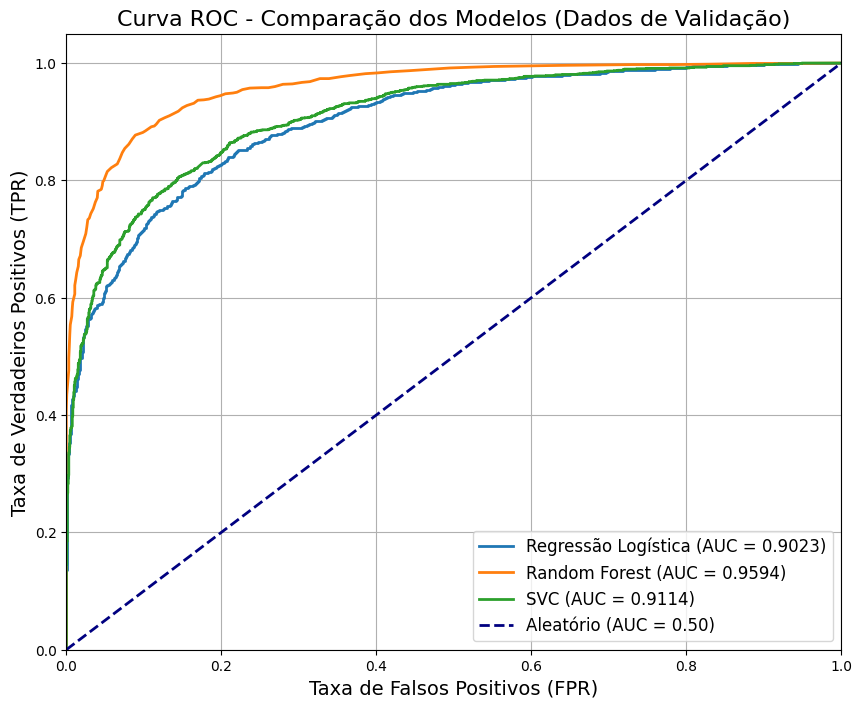

----------------------------------------

------> Teste de Generalização <------
Usando o conjunto de Teste (15%) que NUNCA foi visto pelos modelos.

========== TESTE FINAL: Regressão Logística ==========
--- Métricas para: Regressão Logística (TESTE) ---
Acurácia: 0.8262
F1-Score: 0.8253
Recall: 0.8211
ROC AUC: 0.9117
--------------------

Matriz de Confusão (Teste):
[[1287  261]
 [ 277 1271]]

========== TESTE FINAL: Random Forest ==========
--- Métricas para: Random Forest (TESTE) ---
Acurácia: 0.8999
F1-Score: 0.8995
Recall: 0.8960
ROC AUC: 0.9644
--------------------

Matriz de Confusão (Teste):
[[1399  149]
 [ 161 1387]]

========== TESTE FINAL: SVC ==========
--- Métricas para: SVC (TESTE) ---
Acurácia: 0.8466
F1-Score: 0.8464
Recall: 0.8456
ROC AUC: 0.9216
--------------------

Matriz de Confusão (Teste):
[[1312  236]
 [ 239 1309]]

Interpretação:
Compare as métricas de TESTE (Tarefa 6) com as de VALIDAÇÃO (Tarefa 3).
Se estiverem próximas, o modelo generalizou bem.
Se as métri

In [11]:
print("\n------> Curva ROC e AUC <------")

plt.figure(figsize=(10, 8))
resultados_t5_auc = {}

for nome, modelo in modelos.items():
    # Pegar probabilidades da VALIDAÇÃO
    y_prob_val = modelo.predict_proba(X_val_scaled)[:, 1]
    
    # Calcular FPR, TPR e AUC
    fpr, tpr, _ = roc_curve(y_val, y_prob_val)
    auc = roc_auc_score(y_val, y_prob_val)
    resultados_t5_auc[nome] = auc # Já foi salvo na Tarefa 3, mas recalculamos aqui
    
    # Plotar a curva
    plt.plot(fpr, tpr, label=f'{nome} (AUC = {auc:.4f})', lw=2)

# Linha de referência (aleatório)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório (AUC = 0.50)')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=14)
plt.title('Curva ROC - Comparação dos Modelos (Dados de Validação)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
print("Gerando gráfico ROC...")
plt.show()
print("-" * 40 + "\n")

#####################################################
print("------> Teste de Generalização <------")

print("Usando o conjunto de Teste (15%) que NUNCA foi visto pelos modelos.")

resultados_t6_teste = {}

for nome, modelo in modelos.items():
    print(f"\n{'='*10} TESTE FINAL: {nome} {'='*10}")
    
    # --- Desempenho no TESTE ---
    y_pred_test = modelo.predict(X_test_scaled)
    y_prob_test = modelo.predict_proba(X_test_scaled)[:, 1]
    
    metricas_test = calcular_metricas(f"{nome} (TESTE)", y_test, y_pred_test, y_prob_test)
    resultados_t6_teste[nome] = metricas_test
    
    print("\nMatriz de Confusão (Teste):")
    cm = confusion_matrix(y_test, y_pred_test)
    print(cm)

print("\nInterpretação:")
print("Compare as métricas de TESTE (Tarefa 6) com as de VALIDAÇÃO (Tarefa 3).")
print("Se estiverem próximas, o modelo generalizou bem.")
print("Se as métricas de TESTE caírem muito, houve overfitting no conjunto de validação.")
print("-" * 40 + "\n")

#####################################################

In [14]:
print("\n------> TABELA COMPARATIVA <------")

# 1. Métricas de Treino (T3)
df_treino = pd.DataFrame(resultados_t3_treino).T.add_prefix('Treino_')

# 2. Métricas de Validação (T3)
df_val = pd.DataFrame(resultados_t3_val).T.add_prefix('Val_')

# 3. Métricas do K-Fold (T4) - Pegando Acurácia e AUC
df_kfold = pd.DataFrame(resultados_t4).T
df_kfold_resumo = df_kfold[['accuracy_media', 'accuracy_std', 'roc_auc_media', 'roc_auc_std']]
df_kfold_resumo.columns = ['K-Fold_Acc_Média', 'K-Fold_Acc_Std', 'K-Fold_AUC_Média', 'K-Fold_AUC_Std']

# 4. Métricas de Teste (T6)
df_teste = pd.DataFrame(resultados_t6_teste).T.add_prefix('TESTE_')

# 5. Juntar tudo
df_final = pd.concat([df_treino, df_val, df_kfold_resumo, df_teste], axis=1)

print("\nTabela Comparativa Final:")
print(df_final.to_markdown(floatfmt=".4f"))


------> TABELA COMPARATIVA <------

Tabela Comparativa Final:
|                     |   Treino_Acurácia |   Treino_F1 |   Treino_Recall |   Treino_AUC |   Val_Acurácia |   Val_F1 |   Val_Recall |   Val_AUC |   K-Fold_Acc_Média |   K-Fold_Acc_Std |   K-Fold_AUC_Média |   K-Fold_AUC_Std |   TESTE_Acurácia |   TESTE_F1 |   TESTE_Recall |   TESTE_AUC |
|:--------------------|------------------:|------------:|----------------:|-------------:|---------------:|---------:|-------------:|----------:|-------------------:|-----------------:|-------------------:|-----------------:|-----------------:|-----------:|---------------:|------------:|
| Regressão Logística |            0.8275 |      0.8277 |          0.8294 |       0.9109 |         0.8146 |   0.8147 |       0.8158 |    0.9023 |             0.8291 |           0.0026 |             0.9116 |           0.0030 |           0.8262 |     0.8253 |         0.8211 |      0.9117 |
| Random Forest       |            1.0000 |      1.0000 |          1.0